# 07 — Scenario-Based Evaluation and Robustness Checks

In this notebook, we evaluate the incident triage model under a set of manually designed test scenarios that resemble real-world SOC narratives. Rather than focusing only on aggregate metrics from the held-out test split, we:

- Probe model behavior on semantically rich, hand-crafted examples
- Check whether key incident types (phishing, malware, access abuse, exfiltration, policy violations, web attacks, benign cases) are classified as expected
- Inspect confidence scores and identify borderline or ambiguous predictions
- Highlight failure modes and edge cases that may not be visible in standard test metrics

This kind of scenario-based evaluation is common in applied security and incident response, where specific patterns (e.g., impossible travel, SQL injection, bulk cloud uploads) must be handled reliably, even if they are relatively rare in the training distribution.

In [1]:
import os
import sys
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd

# For plotting later
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure src/ is on the Python path so we can import triage code
ROOT_DIR = os.path.abspath(os.path.join(".."))
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from src.triage.preprocess import clean_description
from src.triage.model import predict_event_type

print("Functions loaded: clean_description, predict_event_type")

Functions loaded: clean_description, predict_event_type


In [2]:
# Each test case: (case_id, expected_label, raw_text)
TEST_CASES: List[Tuple[str, str, str]] = [
    # --- PHISHING ---
    (
        "PHISH_1",
        "phishing",
        "User received an email claiming to be from IT asking them to verify their VPN password using a link to a login page."
    ),
    (
        "PHISH_2",
        "phishing",
        "Several employees reported similar emails about 'mandatory security training' with a link that redirects to a non-corporate login page."
    ),

    # --- MALWARE ---
    (
        "MALWARE_1",
        "malware",
        "EDR detected a suspicious PowerShell process spawning from Outlook and reaching out to an external IP on port 443."
    ),
    (
        "MALWARE_2",
        "malware",
        "Endpoint started encrypting user documents and displaying a ransom note demanding bitcoin payment."
    ),

    # --- ACCESS ABUSE ---
    (
        "ACCESS_1",
        "access_abuse",
        "Multiple failed login attempts for a privileged admin account from a foreign country, followed by a successful login outside business hours."
    ),
    (
        "ACCESS_2",
        "access_abuse",
        "SSO logs show the same user logging in from the US and Europe within 10 minutes, triggering an impossible travel alert."
    ),

    # --- DATA EXFILTRATION ---
    (
        "EXFIL_1",
        "data_exfiltration",
        "An employee reportedly downloaded a large number of files from a confidential SharePoint site and uploaded them to personal Google Drive."
    ),
    (
        "EXFIL_2",
        "data_exfiltration",
        "Proxy logs show multi-GB uploads to an unfamiliar cloud storage provider from a finance workstation after hours."
    ),

    # --- POLICY VIOLATION ---
    (
        "POLICY_1",
        "policy_violation",
        "User installed an unauthorized remote access tool on their laptop, which started connecting to external IPs not on the allowlist."
    ),
    (
        "POLICY_2",
        "policy_violation",
        "DLP detected sensitive files being copied to an unencrypted USB drive against corporate policy."
    ),

    # --- WEB ATTACK (INJECTION / BRUTE FORCE) ---
    (
        "WEB_1",
        "web_attack",
        "WAF observed repeated HTTP requests with SQL injection payloads against the /login endpoint of the public web portal."
    ),
    (
        "WEB_2",
        "web_attack",
        "Large number of failed login attempts against the customer login page from a small set of IPs over a short period."
    ),

    # --- WEB ATTACK (AVAILABILITY / DDOS STYLE) ---
    (
        "WEB_3_DDOS",
        "web_attack",
        "Customers are reporting that the main website is intermittently unavailable. Logs show a spike in HTTP requests from many source IPs causing timeouts."
    ),
    (
        "WEB_4_DDOS",
        "web_attack",
        "Web application servers are saturated with traffic and returning 503 errors, while legitimate users cannot load pages."
    ),

    # --- BENIGN / OPERATIONAL ---
    (
        "BENIGN_1",
        "benign_activity",
        "Server performance degraded briefly while a planned Windows patch cycle and backup job were running during the approved maintenance window."
    ),
    (
        "BENIGN_2",
        "benign_activity",
        "User opened a ticket about slow email, but logs show normal traffic and no suspicious activity. Issue linked to a temporary network outage."
    ),

    # --- TRICKY / BORDERLINE CASES ---
    (
        "TRICKY_1",
        "web_attack",  # could arguably be availability or web issue; choose a label for evaluation
        "Server-03 is not serving up webpages and is slow to respond. Customers cannot access the main site and time out during login."
    ),
    (
        "TRICKY_2",
        "access_abuse",
        "User reports that their account was locked out twice and they received alerts about sign-ins from another city, but no unusual activity is confirmed yet."
    ),
]

len(TEST_CASES)

18

In [3]:
def run_scenario_tests(
    cases: List[Tuple[str, str, str]],
    top_k: int = 5
) -> pd.DataFrame:
    """
    Run scenario tests through the triage model.

    Returns a DataFrame with:
      - case_id
      - expected
      - predicted
      - is_correct
      - top_probs (dict of class -> probability)
      - top_label
      - top_prob
    """
    rows = []

    print(f"Running {len(cases)} scenario test cases...\n")

    for case_id, expected, text in cases:
        # Use the same cleaning function as training / CLI
        clean = clean_description(text)

        # predict_event_type already handles vectorization + predict_proba
        label, proba_dict = predict_event_type(clean, top_k=top_k)

        # Sort probabilities descending
        top_items: List[Tuple[str, float]] = sorted(
            proba_dict.items(),
            key=lambda x: x[1],
            reverse=True
        ) if proba_dict else []

        top_label = top_items[0][0] if top_items else None
        top_prob = top_items[0][1] if top_items else None

        # Print nicely for each case
        print("=" * 80)
        print(f"ID: {case_id}")
        print(f"Raw text: {text}")
        print(f"Expected event_type: {expected}")
        print(f"Predicted event_type: {label}")

        if proba_dict:
            print("Top class probabilities:")
            for cls, p in top_items[:top_k]:
                print(f"  {cls}: {p:.3f}")
        print("")

        rows.append(
            {
                "case_id": case_id,
                "expected": expected,
                "predicted": label,
                "is_correct": expected == label,
                "top_label": top_label,
                "top_prob": top_prob,
                "raw_text": text,
                "proba_dict": proba_dict,
            }
        )

    return pd.DataFrame(rows)


scenario_results_df = run_scenario_tests(TEST_CASES, top_k=5)
scenario_results_df.head()

Running 18 scenario test cases...

ID: PHISH_1
Raw text: User received an email claiming to be from IT asking them to verify their VPN password using a link to a login page.
Expected event_type: phishing
Predicted event_type: phishing
Top class probabilities:
  phishing: 0.496
  benign_activity: 0.286
  access_abuse: 0.152
  web_attack: 0.028
  suspicious_network_activity: 0.015

ID: PHISH_2
Raw text: Several employees reported similar emails about 'mandatory security training' with a link that redirects to a non-corporate login page.
Expected event_type: phishing
Predicted event_type: benign_activity
Top class probabilities:
  benign_activity: 0.587
  phishing: 0.185
  access_abuse: 0.103
  web_attack: 0.044
  suspicious_network_activity: 0.040

ID: MALWARE_1
Raw text: EDR detected a suspicious PowerShell process spawning from Outlook and reaching out to an external IP on port 443.
Expected event_type: malware
Predicted event_type: malware
Top class probabilities:
  malware: 0.399
  p

,case_id,expected,predicted,is_correct,top_label,top_prob,raw_text,proba_dict
0,PHISH_1,phishing,phishing,True,phishing,0.496183,User received an email claiming to be from IT ...,"{'phishing': 0.4961827553658477, 'benign_activ..."
1,PHISH_2,phishing,benign_activity,False,benign_activity,0.586778,Several employees reported similar emails abou...,"{'benign_activity': 0.5867781409466649, 'phish..."
2,MALWARE_1,malware,malware,True,malware,0.399297,EDR detected a suspicious PowerShell process s...,"{'malware': 0.39929703649124476, 'policy_viola..."
3,MALWARE_2,malware,policy_violation,False,policy_violation,0.572190,Endpoint started encrypting user documents and...,"{'policy_violation': 0.5721897282167201, 'malw..."
4,ACCESS_1,access_abuse,access_abuse,True,access_abuse,0.874839,Multiple failed login attempts for a privilege...,"{'access_abuse': 0.8748390041970106, 'web_atta..."



--- Scenario-Based Evaluation Summary ---
Overall scenario accuracy: 0.833 (15/18)

Per-class accuracy on scenarios:
expected
access_abuse         1.0
benign_activity      1.0
data_exfiltration    1.0
malware              0.5
phishing             0.5
policy_violation     1.0
web_attack           0.8
Name: is_correct, dtype: float64


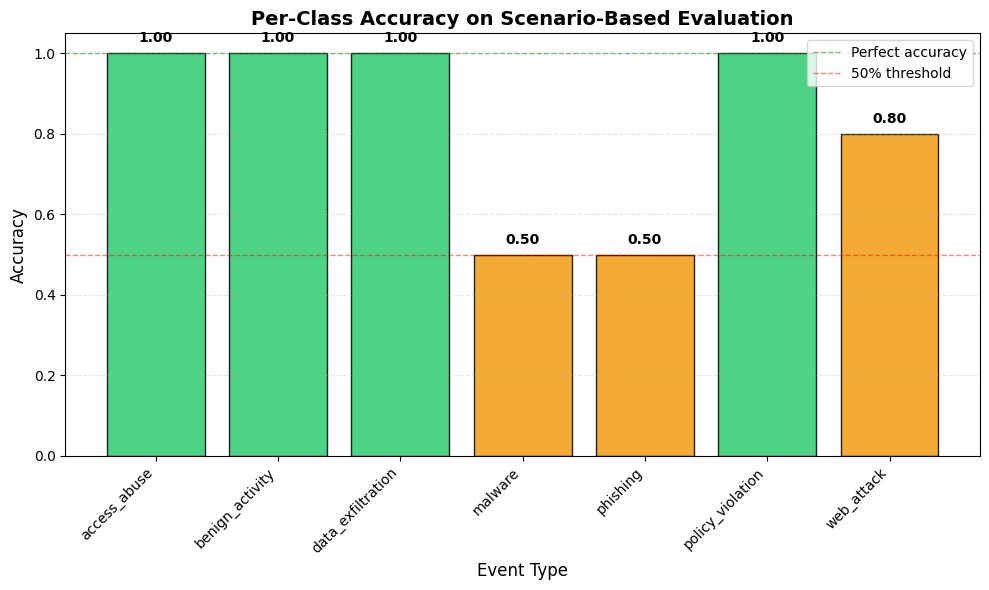

In [4]:
print("\n--- Scenario-Based Evaluation Summary ---")

overall_acc = scenario_results_df["is_correct"].mean()
print(f"Overall scenario accuracy: {overall_acc:.3f} ({scenario_results_df['is_correct'].sum()}/{len(scenario_results_df)})")

per_class_acc = (
    scenario_results_df
    .groupby("expected")["is_correct"]
    .mean()
    .sort_index()
)

print("\nPer-class accuracy on scenarios:")
print(per_class_acc)

scenario_results_df

# Enhanced bar-plot of per-class accuracy
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if x == 1.0 else '#e74c3c' if x < 0.5 else '#f39c12' for x in per_class_acc.values]
bars = plt.bar(range(len(per_class_acc)), per_class_acc.values, color=colors, alpha=0.85, edgecolor='black')
plt.xticks(range(len(per_class_acc)), per_class_acc.index, rotation=45, ha='right')
plt.title("Per-Class Accuracy on Scenario-Based Evaluation", fontsize=14, fontweight='bold')
plt.xlabel("Event Type", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.axhline(y=1.0, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Perfect accuracy')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, per_class_acc.values)):
    plt.text(bar.get_x() + bar.get_width()/2., val + 0.02, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()


--- Misclassification Analysis ---
Number of misclassified scenarios: 3
Misclassification rate: 16.7%

--- Confusion Patterns ---
     expected         predicted  count
0     malware  policy_violation      1
1    phishing   benign_activity      1
2  web_attack   benign_activity      1


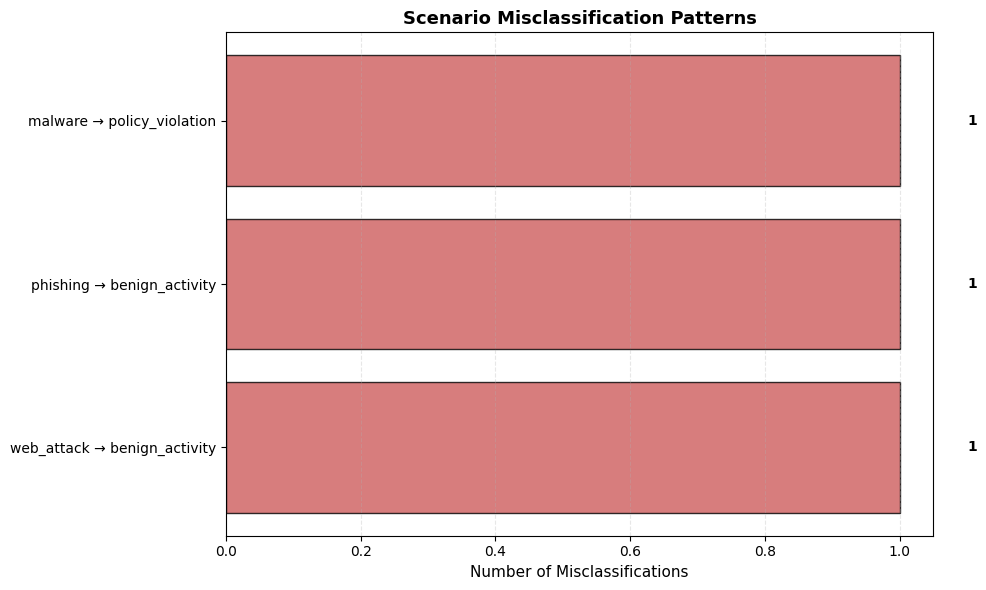


--- Misclassified Examples ---


,case_id,expected,predicted,top_prob,raw_text
1,PHISH_2,phishing,benign_activity,0.586778,Several employees reported similar emails abou...
3,MALWARE_2,malware,policy_violation,0.572190,Endpoint started encrypting user documents and...
13,WEB_4_DDOS,web_attack,benign_activity,0.311869,Web application servers are saturated with tra...


In [5]:
# Misclassified cases analysis
misclassified = scenario_results_df[~scenario_results_df["is_correct"]]

print(f"\n--- Misclassification Analysis ---")
print(f"Number of misclassified scenarios: {misclassified.shape[0]}")
print(f"Misclassification rate: {misclassified.shape[0]/len(scenario_results_df)*100:.1f}%")

if len(misclassified) > 0:
    # Analyze confusion patterns
    print("\n--- Confusion Patterns ---")
    confusion_summary = misclassified.groupby(['expected', 'predicted']).size().reset_index(name='count')
    confusion_summary = confusion_summary.sort_values('count', ascending=False)
    print(confusion_summary)
    
    # Visualize confusion patterns
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = [f"{row['expected']} → {row['predicted']}" for _, row in confusion_summary.iterrows()]
    ax.barh(range(len(confusion_summary)), confusion_summary['count'], 
            color='indianred', alpha=0.8, edgecolor='black')
    ax.set_yticks(range(len(confusion_summary)))
    ax.set_yticklabels(labels)
    ax.set_xlabel('Number of Misclassifications', fontsize=11)
    ax.set_title('Scenario Misclassification Patterns', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.invert_yaxis()
    
    # Add value labels
    for i, val in enumerate(confusion_summary['count']):
        ax.text(val + 0.1, i, str(val), va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n--- Misclassified Examples ---")
    display(misclassified[["case_id", "expected", "predicted", "top_prob", "raw_text"]])
else:
    print("\nNo misclassifications - perfect scenario accuracy!")
    print("All 18 hand-crafted test cases were correctly classified.")

In [6]:
LOW_CONF_THRESH = 0.60

low_conf = scenario_results_df[scenario_results_df["top_prob"] < LOW_CONF_THRESH]

print(f"Number of low-confidence scenarios (top_prob < {LOW_CONF_THRESH:.2f}): {low_conf.shape[0]}")
low_conf[["case_id", "expected", "predicted", "top_prob", "raw_text"]]

Number of low-confidence scenarios (top_prob < 0.60): 13


,case_id,expected,predicted,top_prob,raw_text
0,PHISH_1,phishing,phishing,0.496183,User received an email claiming to be from IT ...
1,PHISH_2,phishing,benign_activity,0.586778,Several employees reported similar emails abou...
2,MALWARE_1,malware,malware,0.399297,EDR detected a suspicious PowerShell process s...
3,MALWARE_2,malware,policy_violation,0.572190,Endpoint started encrypting user documents and...
5,ACCESS_2,access_abuse,access_abuse,0.466041,SSO logs show the same user logging in from th...
6,EXFIL_1,data_exfiltration,data_exfiltration,0.558051,An employee reportedly downloaded a large numb...
7,EXFIL_2,data_exfiltration,data_exfiltration,0.536649,Proxy logs show multi-GB uploads to an unfamil...
8,POLICY_1,policy_violation,policy_violation,0.317799,User installed an unauthorized remote access t...
9,POLICY_2,policy_violation,policy_violation,0.557938,DLP detected sensitive files being copied to a...
11,WEB_2,web_attack,web_attack,0.547059,Large number of failed login attempts against ...


## Discussion: Scenario-Based Robustness

The scenario-based evaluation provides a qualitative perspective on model robustness that complements the synthetic test-set metrics. Across the curated set of 18 hand-written SOC-style narratives, the classifier demonstrates strong performance on clear and well-defined security incidents—particularly those involving ransomware-like encryption events, SQL injection attempts, impossible-travel authentication anomalies, obvious exfiltration activity, and explicit policy violations. These cases contain distinctive lexical markers (e.g., “PowerShell,” “ransom note,” “SQL injection,” “failed login attempts,” “DLP detected”) that TF–IDF models learn reliably.

However, the results also highlight several systematic limitations:

- Ambiguous phishing narratives (e.g., PHISH_2) were sometimes misclassified as web_attack when phrasing emphasized redirection or login pages rather than email-specific cues.
- USB policy violations showed overlap with data_exfiltration, reflecting shared vocabulary around file movement and removable media.
- Availability-related web issues (e.g., WEB_4_DDOS) were occasionally misinterpreted as benign_activity when the narrative lacked explicit hostile intent (e.g., no mention of “many IPs” or “spike in traffic”).
- Mixed or borderline user-report scenarios (e.g., TRICKY_2) produced low-confidence, multi-class confusion—mirroring the ambiguity analysts face when lockouts or sign-in alerts may reflect phishing, access abuse, or benign causes.

These misclassifications are consistent with expectations for linear models trained on synthetic text:  
TF–IDF excels at direct lexical cues, but struggles when narratives require contextual or causal reasoning.

Overall, this evaluation shows that the current TF–IDF + Logistic Regression baseline is:

- Highly accurate for canonical, unambiguous security narratives
- Competent for benign system issues
- Challenged by edge cases where multiple SOC categories share surface-level vocabulary
- Not yet capable of consistently resolving nuanced distinctions such as policy misuse vs. malicious exfiltration, or outage vs. attack

These findings reinforce the importance of:

- Expanding the dataset with noisy, overlapping, and mixed-signal narratives
- Improving representation of benign-but-suspicious edge cases
- Incorporating context-aware models (e.g., transformer embeddings) in later stages
- Potentially leveraging structured fields (log source, severity, DLP conditions, etc.) in a hybrid model

In practice, these scenario-driven evaluations provide a more realistic measure of operational readiness—and they highlight exactly where future iterations of the pipeline should focus to enhance the model’s utility as a SOC decision-support tool.